In [1]:
import os
import pandas as pd
import numpy as np
import fasttext
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import torch
from sklearn.metrics import accuracy_score, classification_report
import matplotlib.pyplot as plt
import seaborn as sns



1941
1593
265
83


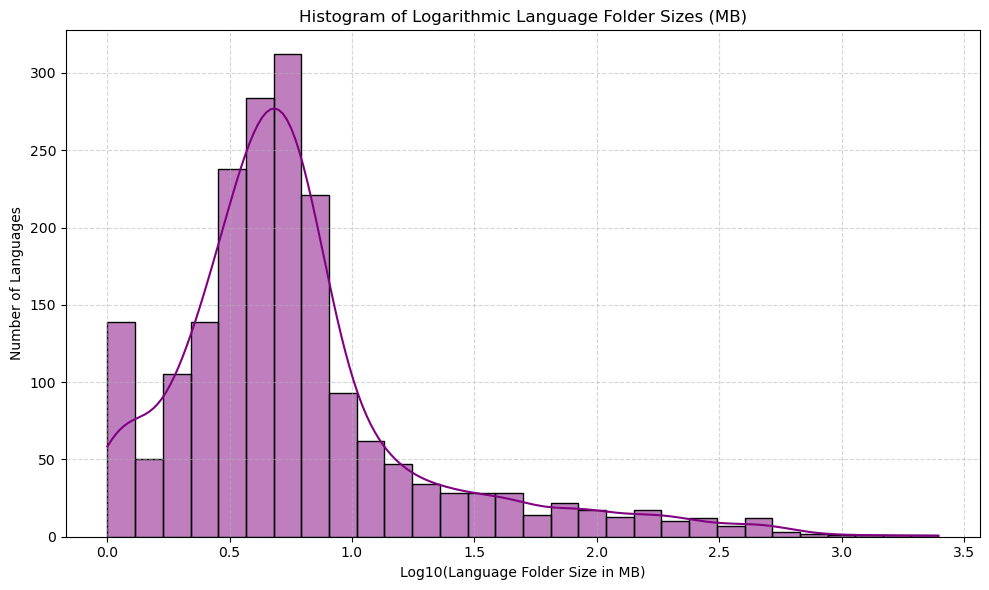

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

base_path = r'C:\Users\jortk\Documents\v3.1' #data from complete Glotid-C corpus (41GB) is saved on my PC in this location
data = []

# Calculate total size (in MB) per language folder
language_sizes = {}

for lang_script in os.listdir(base_path):
    lang_path = os.path.join(base_path, lang_script)
    total_size = 0
    
    for root, dirs, files in os.walk(lang_path):
        for file in files:
            file_path = os.path.join(root, file)
            total_size += os.path.getsize(file_path)
            
    language_sizes[lang_script] = total_size / (1024 * 1024)  # Convert size to MB

# Convert to DataFrame for easy handling
sizes_df = pd.DataFrame.from_dict(language_sizes, orient='index', columns=['size_MB'])
sizes_small = sizes_df[sizes_df['size_MB'] < 10]
sizes_medium = sizes_df[(sizes_df['size_MB'] >= 10) & (sizes_df['size_MB']<100)]
sizes_large = sizes_df[sizes_df['size_MB'] >= 100]
print(len(sizes_df))
print(len(sizes_small))
print(len(sizes_medium))
print(len(sizes_large))

# Compute the log (base 10) of sizes clearly
sizes_df['log_size_MB'] = np.log10(sizes_df['size_MB'] + 1)  # +1 to avoid log(0)

# Plot histogram of log-sizes
plt.figure(figsize=(10, 6))
sns.histplot(sizes_df['log_size_MB'], bins=30, kde=True, color='purple')

# Clearly label axes
plt.title('Histogram of Logarithmic Language Folder Sizes (MB)')
plt.xlabel('Log10(Language Folder Size in MB)')
plt.ylabel('Number of Languages')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.savefig("hist_size.jpg")
plt.show()


“Note that GlotLID was trained on the GlotLID-C corpus, which is also used here for evaluation. While this introduces the possibility of training-test overlap, we mitigate this by using randomly sampled and truncated sentences not seen during training, and we focus on the relative impact of input length rather than absolute performance scores.”

In [4]:
import os
import pandas as pd
import random

# Define input path and output location
base_path = r'C:\Users\jortk\Documents\v3.1'

data = [] 

output_path = r'C:\Users\jortk\OneDrive\OneDrive Documenten\ENSAE\ENSAE ML for NLP\Project\language_identification_dataset5_truncated.csv'

# Define sentence length bins
bins = [(0, 20), (20, 40), (40, 60), (60, 80), (80, 100)]
bin_labels = ['0-20', '20-40', '40-60', '60-80', '80-100']


# Safe truncation
def safe_truncate(text, max_len):
    if len(text) <= max_len:
        return text
    truncated = text[:max_len+1].rsplit(' ', 1)[0]
    return truncated if truncated else text[:max_len]

# Step 1: Calculate resource group per language_script
language_sizes = {}
for lang_script in os.listdir(base_path):
    lang_path = os.path.join(base_path, lang_script)
    total_size = 0
    for root, _, files in os.walk(lang_path):
        for file in files:
            total_size += os.path.getsize(os.path.join(root, file))
    size_mb = total_size / (1024 * 1024)
    if size_mb < 10:
        resource = 'Low'
    elif size_mb < 100:
        resource = 'Medium'
    else:
        resource = 'High'
    language_sizes[lang_script] = {'size_mb': size_mb, 'resource_group': resource}

# Step 2: Write header to output file
with open(output_path, 'w', encoding='utf-8') as out:
    out.write('sentence,language,length_category,resource_group\n')

# Step 3: Stream + truncate
for lang_script in os.listdir(base_path):
    lang_code = lang_script.split('_')[0]
    resource_group = language_sizes.get(lang_script, {}).get('resource_group', 'Unknown')
    lang_path = os.path.join(base_path, lang_script)

    if not os.path.isdir(lang_path):
        continue
    sentences_loaded = 0
    for file_name in os.listdir(lang_path):
        file_path = os.path.join(lang_path, file_name)
        
        with open(file_path, 'r', encoding='utf-8', errors='ignore') as f_in, \
             open(output_path, 'a', encoding='utf-8') as f_out:
            
            for line in f_in:
                sentence = line.strip()

                if not sentence or len(sentence) <= 100:
                    continue  # Only use unseen sentences

                min_len, max_len = random.choice(bins)
                target_len = random.randint(min_len, max_len - 1)
                truncated = safe_truncate(sentence, target_len)

                if min_len <= len(truncated) < max_len:
                    bin_label = f"{min_len}-{max_len}"
                    # Escape inner quotes, write CSV row
                    clean_sentence = truncated.replace('"', '').replace('\n', ' ').replace('\r', ' ')
                    row = f'"{clean_sentence}",{lang_code},{bin_label},{resource_group}\n'
                    f_out.write(row)
                    sentences_loaded += 1
                if sentences_loaded>1000:
                    break
            if sentences_loaded >= 1000:
                break

In [5]:
df = pd.read_csv(r'C:\Users\jortk\OneDrive\OneDrive Documenten\ENSAE\ENSAE ML for NLP\Project\language_identification_dataset5_truncated.csv')
print("\nSample of the loaded dataset:")
print(df.head(10))

print("\nResource group distribution:")
print(df['resource_group'].value_counts())


Sample of the loaded dataset:
                                            sentence language length_category  \
0  Iti i Jesu ana’a’agir wabih, aiwob ana efane i...      aai           40-60   
1  Abraham natun i Isaac, naatu Isaac natun i Jac...      aai           60-80   
2  Naatu Judah natunatun i Perez tain Zerah hairi...      aai           60-80   
3      Naatu Salmon natun i Boaz, hinah wabin Rahab,      aai           40-60   
4           Josiah natun i Jeconiah, Jeconiah taitin      aai           40-60   
5  Babilonane himatabir maiye hinan ufunamaim Jec...      aai          80-100   
6  Imih Abraham ana veya’amaim busuruf re na Davi...      aai           40-60   
7  Jesu Keriso ana tufuw an i iti na’atube busuru...      aai           60-80   
8                                           Baise ma      aai            0-20   
9                I boro kek orot nayai, o wabin Jesu      aai           20-40   

  resource_group  
0            Low  
1            Low  
2            Low  
3

In [46]:
# Ensure all sentences are strings
df = df[df['sentence'].notna()]
df['sentence'] = df['sentence'].astype(str)

df['sentence_length'] = df['sentence'].apply(len)
bins = [0, 20, 40, 60, 80, 100]
labels = ['0-20', '20-40', '40-60', '60-80', '80-100']
#bin_limits = list(zip(bins[:-1], bins[1:]))
df['length_category'] = pd.cut(df['sentence_length'], bins=bins, labels=labels, right=False)

# Group and count
#bin_counts = df['length_category'].value_counts()
bin_counts = df.groupby(['resource_group', 'length_category']).size().unstack(fill_value=0)
print("Current bin sizes:\n", bin_counts)

C:\Users\jortk\AppData\Local\Temp\ipykernel_13708\2083061363.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = df.groupby(['resource_group', 'length_category']).size().unstack(fill_value=0)


Current bin sizes:
 length_category    0-20   20-40   40-60   60-80  80-100
resource_group                                         
High              19089   16266   15887   15916   15918
Low              332571  280358  278953  279579  279066
Medium            61503   51363   50641   50658   50780


In [7]:
import fasttext
from huggingface_hub import hf_hub_download

model_path_openlid = hf_hub_download(repo_id="laurievb/OpenLID", filename="model.bin")
openlid_model = fasttext.load_model(model_path_openlid)
def predict_openlid(sentence):
    label = openlid_model.predict(sentence)[0][0].replace('__label__', '').split('_')[0]
    return label

model_path_glotlid = hf_hub_download(repo_id="cis-lmu/glotlid", filename="model.bin")
model_glotlid = fasttext.load_model(model_path_glotlid)
def predict_glotlid(sentence):
    label = model_glotlid.predict(sentence)[0][0].replace("__label__", "").split('_')[0]
    return label


In [8]:
high_resource_langs = df[df['resource_group'] == 'High']['language'].unique()
high_resource_langs = set(high_resource_langs)
#print(high_resource_langs)

openlid_labels = set(
    label.replace('__label__', '').split('_')[0]  # remove __label__ and script
    for label in openlid_model.get_labels()
)
#print(openlid_labels)

glotlid_labels = set(
    label.replace('__label__', '').split('_')[0]  # Remove script from labels like 'eng_Latn'
    for label in model_glotlid.get_labels()
)

#print(glotlid_labels)

missing_in_openlid = high_resource_langs - openlid_labels
missing_in_glotlid = high_resource_langs - glotlid_labels

print("Languages missing in OpenLID:", sorted(missing_in_openlid))
print("Languages missing in GlotLID:", sorted(missing_in_glotlid))

Languages missing in OpenLID: ['abk', 'cmn', 'ekk', 'fas', 'fil', 'hbs', 'hil', 'ton']
Languages missing in GlotLID: ['hbs']


In [9]:
missing_langs = ['abk', 'cmn', 'ekk', 'fas', 'fil', 'hbs', 'hil', 'ton']
df_high = df[df['resource_group']=='High'].copy()
# Remove from your high-resource DataFrame
df_high = df_high[~df_high['language'].isin(missing_langs)].reset_index(drop=True)
# Low-resource languages (GlotLID only)
df_low = df[df['resource_group']=='Low'].copy()

#check
high_resource_langs = df_high['language'].unique()
high_resource_langs = set(high_resource_langs)
#print(high_resource_langs)

missing_in_openlid = high_resource_langs - openlid_labels
missing_in_glotlid = high_resource_langs - glotlid_labels

print("Languages missing in OpenLID:", sorted(missing_in_openlid))
print("Languages missing in GlotLID:", sorted(missing_in_glotlid))



Languages missing in OpenLID: []
Languages missing in GlotLID: []


In [44]:
# Group and count
#bin_counts = df['length_category'].value_counts()
bin_counts = df_high.groupby(['resource_group', 'length_category']).size().unstack(fill_value=0)
print("Current bin sizes:\n", bin_counts)
smallest_bin_size_high = bin_counts.min().min()
#print("Smallest bin size: ", bin_counts.min().min())

# Group and count
#bin_counts = df['length_category'].value_counts()
bin_counts = df_low.groupby(['resource_group', 'length_category']).size().unstack(fill_value=0)
print("Current bin sizes:\n", bin_counts)
smallest_bin_size_low = bin_counts.min().min()

smallest_bin_size = min(smallest_bin_size_high, smallest_bin_size_low)
print("Smallest bin size: ", smallest_bin_size)


C:\Users\jortk\AppData\Local\Temp\ipykernel_13708\1603714578.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = df_high.groupby(['resource_group', 'length_category']).size().unstack(fill_value=0)
C:\Users\jortk\AppData\Local\Temp\ipykernel_13708\1603714578.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_counts = df_low.groupby(['resource_group', 'length_category']).size().unstack(fill_value=0)


Current bin sizes:
 length_category   0-20  20-40  40-60  60-80  80-100
resource_group                                     
High             17366  14662  14293  14349   14398
Current bin sizes:
 length_category    0-20   20-40   40-60   60-80  80-100
resource_group                                         
Low              332571  280358  278953  279579  279066
Smallest bin size:  14293


In [48]:
subset_size = smallest_bin_size
# Sample from each length category
df_subset_high = df_high.groupby('length_category', group_keys=False, observed=False)\
                       .apply(lambda x: x.sample(min(len(x), subset_size), random_state=42))\
                       .reset_index(drop=True)
df_subset_low = df_low.groupby('length_category', group_keys=False, observed=False)\
                       .apply(lambda x: x.sample(min(len(x), subset_size), random_state=42))\
                       .reset_index(drop=True)

#check
print("High resource languages")
print(df_subset_high['length_category'].value_counts().sort_index())
print("Low resource languages")
print(df_subset_low['length_category'].value_counts().sort_index())

C:\Users\jortk\AppData\Local\Temp\ipykernel_13708\2377174516.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), subset_size), random_state=42))\


High resource languages
length_category
0-20      14293
20-40     14293
40-60     14293
60-80     14293
80-100    14293
Name: count, dtype: int64
Low resource languages
length_category
0-20      14293
20-40     14293
40-60     14293
60-80     14293
80-100    14293
Name: count, dtype: int64


C:\Users\jortk\AppData\Local\Temp\ipykernel_13708\2377174516.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(min(len(x), subset_size), random_state=42))\


In [50]:
df_subset_high['pred_glotlid'] = df_subset_high['sentence'].apply(predict_glotlid)
df_subset_high['pred_openlid'] = df_subset_high['sentence'].apply(predict_openlid)
df_subset_low['pred_glotlid'] = df_subset_low['sentence'].apply(predict_glotlid)

In [51]:
from sklearn.metrics import accuracy_score, classification_report

def eval_metrics(df, true_col, pred_col):
    df_clean = df[[true_col, pred_col]].dropna().copy()

    # Convert both to strings, drop rows with non-string predictions
    df_clean[true_col] = df_clean[true_col].astype(str)
    df_clean[pred_col] = df_clean[pred_col].astype(str)

    # Optional: filter out invalid predictions like 'nan' or 'None'
    df_clean = df_clean[
        (~df_clean[true_col].isin(['nan', 'None'])) &
        (~df_clean[pred_col].isin(['nan', 'None']))
    ]
    support = len(df_clean)
    
    if df_clean.empty:
        return 0.0, 0.0, 0.0  # Safe default if no data left

    acc = accuracy_score(df_clean[true_col], df_clean[pred_col])
    report = classification_report(df_clean[true_col], df_clean[pred_col], output_dict=True, zero_division=0)
    macro_f1 = report['macro avg']['f1-score']

    # Compute FPR per class and take macro average
    labels = [k for k in report.keys() if k not in ['accuracy', 'macro avg', 'weighted avg']]
    fprs = []

    for label in labels:
        support_i = report[label]['support']
        recall = report[label]['recall']
        precision = report[label]['precision']
        tp = recall * support_i
        fn = support_i - tp
        if precision > 0:
            fp = tp * (1 - precision) / precision
        else:
            fp = 0
        tn = support - (tp + fp + fn)
        fpr = fp / (fp + tn) if (fp + tn) > 0 else 0
        fprs.append(fpr)

    macro_fpr = sum(fprs) / len(fprs) if fprs else 0

    return acc, macro_f1, support, macro_fpr

#    return acc, macro_f1, support


results = []

length_labels = ['0-20', '20-40', '40-60', '60-80', '80-100']

# High-resource
for length in length_labels:
    subset = df_subset_high[df_subset_high['length_category']==length]
    acc_glotlid, f1_glotlid,support_glotlid, macro_fpr_glotlid = eval_metrics(subset, 'language', 'pred_glotlid')
    acc_openlid, f1_openlid,support_openlid, macro_fpr_openlid = eval_metrics(subset, 'language', 'pred_openlid')
    results.append({'Model':'GlotLID', 'Resource':'High', 'Length':length, 'Accuracy':acc_glotlid, 'F1':f1_glotlid, "FPR": macro_fpr_glotlid, 'Support': support_glotlid})
    results.append({'Model':'OpenLID', 'Resource':'High', 'Length':length, 'Accuracy':acc_openlid, 'F1':f1_openlid,  "FPR": macro_fpr_openlid, 'Support': support_openlid})

# Low-resource (only GlotLID)
for length in length_labels:
    subset = df_subset_low[df_subset_low['length_category']==length]
    acc_glotlid, f1_glotlid,support_glotlid, macro_fpr_glotlid = eval_metrics(subset, 'language', 'pred_glotlid')
    results.append({'Model':'GlotLID', 'Resource':'Low', 'Length':length, 'Accuracy':acc_glotlid, 'F1':f1_glotlid, "FPR": macro_fpr_glotlid, 'Support': support_glotlid})

results_df = pd.DataFrame(results)


In [52]:
print(results_df)

      Model Resource  Length  Accuracy        F1       FPR  Support
0   GlotLID     High    0-20  0.612887  0.222289  0.000760    14293
1   OpenLID     High    0-20  0.664591  0.341146  0.001462    14293
2   GlotLID     High   20-40  0.955433  0.430845  0.000121    14293
3   OpenLID     High   20-40  0.948996  0.539009  0.000238    14293
4   GlotLID     High   40-60  0.976702  0.598385  0.000061    14293
5   OpenLID     High   40-60  0.975093  0.655258  0.000130    14293
6   GlotLID     High   60-80  0.979361  0.653258  0.000039    14293
7   OpenLID     High   60-80  0.978171  0.663650  0.000113    14293
8   GlotLID     High  80-100  0.983628  0.748070  0.000019    14293
9   OpenLID     High  80-100  0.984468  0.770775  0.000096    14293
10  GlotLID      Low    0-20  0.212414  0.248780  0.000073    14274
11  GlotLID      Low   20-40  0.868847  0.763300  0.000035    14281
12  GlotLID      Low   40-60  0.969045  0.913930  0.000010    14279
13  GlotLID      Low   60-80  0.983818  0.949007

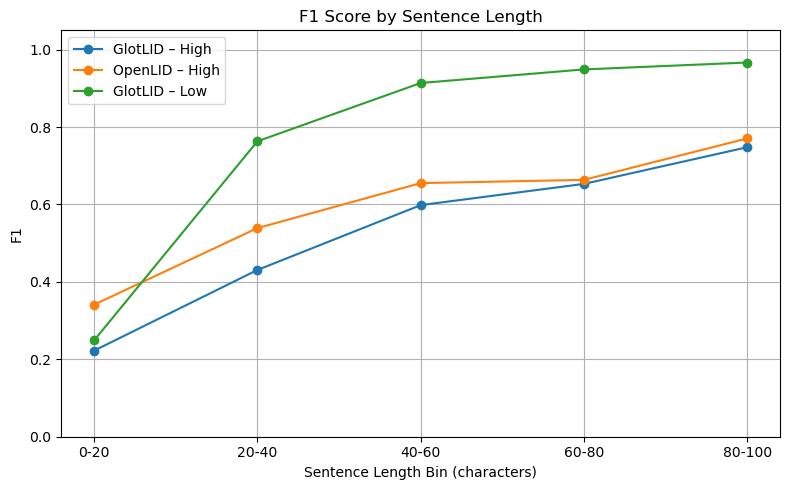

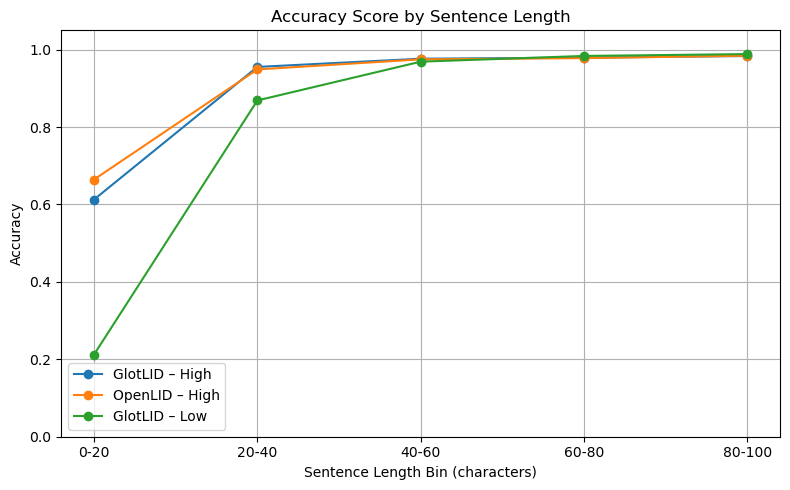

In [64]:
import matplotlib.pyplot as plt

# Define sentence length bin order
length_order = ['0-20', '20-40', '40-60', '60-80', '80-100']
metrics = ['F1', 'Accuracy']

# Filter combinations
def get_data(model, resource):
    df = results_df[
        (results_df['Model'] == model) &
        (results_df['Resource'] == resource) &
        (results_df['Length'].isin(length_order))
    ]
    return df.set_index('Length').reindex(length_order).reset_index()

# Labels for legend
label_map = {
    ('GlotLID', 'High'): 'GlotLID – High',
    ('OpenLID', 'High'): 'OpenLID – High',
    ('GlotLID', 'Low'): 'GlotLID – Low'
}

colors = {
    'GlotLID – High': '#1f77b4',
    'OpenLID – High': '#ff7f0e',
    'GlotLID – Low': '#2ca02c'
}

# Plotting loop
for metric in metrics:
    plt.figure(figsize=(8, 5))

    for model, resource in [('GlotLID', 'High'), ('OpenLID', 'High'), ('GlotLID', 'Low')]:
        df_plot = get_data(model, resource)
        label = label_map[(model, resource)]
        plt.plot(df_plot['Length'], df_plot[metric], marker='o', label=label, color=colors[label])

    plt.title(f'{metric} Score by Sentence Length')
    plt.xlabel('Sentence Length Bin (characters)')
    plt.ylabel(metric)
    plt.ylim(0, 1.05)
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.savefig(f"{metric}.jpg")
    plt.show()


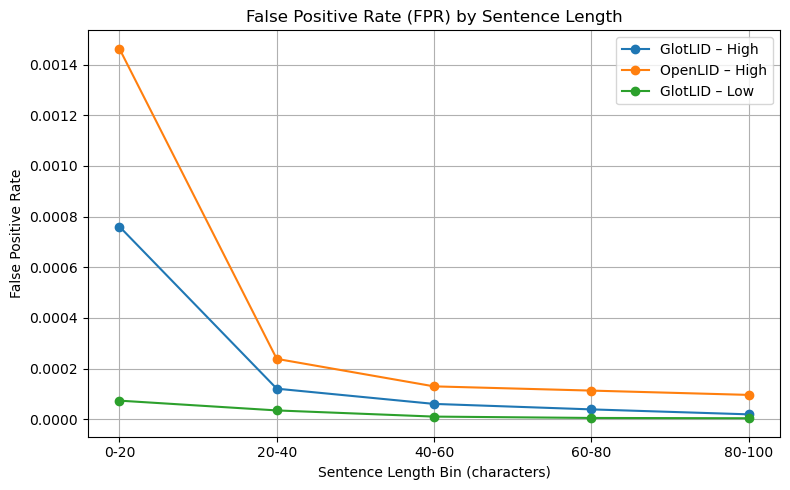

In [66]:
import matplotlib.pyplot as plt

# Define the length bin order
length_order = ['0-20', '20-40', '40-60', '60-80', '80-100']

# Create the FPR plot
plt.figure(figsize=(8, 5))

# Plot for GlotLID High
df_plot = results_df[(results_df['Model'] == 'GlotLID') & (results_df['Resource'] == 'High')]
df_plot = df_plot.set_index('Length').reindex(length_order).reset_index()
plt.plot(df_plot['Length'], df_plot['FPR'], marker='o', label='GlotLID – High')

# Plot for OpenLID High
df_plot = results_df[(results_df['Model'] == 'OpenLID') & (results_df['Resource'] == 'High')]
df_plot = df_plot.set_index('Length').reindex(length_order).reset_index()
plt.plot(df_plot['Length'], df_plot['FPR'], marker='o', label='OpenLID – High')

# Plot for GlotLID Low
df_plot = results_df[(results_df['Model'] == 'GlotLID') & (results_df['Resource'] == 'Low')]
df_plot = df_plot.set_index('Length').reindex(length_order).reset_index()
plt.plot(df_plot['Length'], df_plot['FPR'], marker='o', label='GlotLID – Low')

# Final formatting
plt.title('False Positive Rate (FPR) by Sentence Length')
plt.xlabel('Sentence Length Bin (characters)')
plt.ylabel('False Positive Rate')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("fpr.jpg")
plt.show()
